## Import Functions and Spark Config

In [3]:
%run ./read_file.ipynb

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/23 23:35:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/23 23:35:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Set Environment

In [4]:
# env - dev / prod
# size - small / medium / large
env='prod'
size='medium'

## Data Processing

In [5]:
df_ecarbro = readCheckpoint('ecar-bro', env, size)

23/02/23 23:35:47 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


--- 9.35029935836792 seconds ---


In [7]:
df_ecarbro.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,dest_ip,dest_port,direction,image_path,l4protocol,src_ip,src_port,event_minute,event_day,event_hour
0,INFO,4dcada9c-8adf-4a97-8a4b-0bf825772242,SysClient0117.systemia.com,397822bf-c119-4e5e-a753-18dbc0cfe5fb,FLOW,55f24ac8-35b3-4304-ae3e-f443da4d4069,2484,3852,SYSTEMIACOM\scrazymindz,-1,...,None,NaN,None,None,None,None,NaN,0,17,16
1,INFO,4dcada9c-8adf-4a97-8a4b-0bf825772242,SysClient0117.systemia.com,5c0c257e-596d-4853-930d-f1bed67fa8dc,FLOW,484f9f85-8697-4a8b-a780-cc3cf41b789a,2484,3852,SYSTEMIACOM\scrazymindz,-1,...,None,NaN,None,None,None,None,NaN,0,17,16
2,INFO,4dcada9c-8adf-4a97-8a4b-0bf825772242,SysClient0117.systemia.com,00eece7f-2434-441d-80fc-1fb982557ad7,FLOW,b8bf74ec-0fa7-42d3-a3a0-7dc6348a3bbf,2484,3852,SYSTEMIACOM\scrazymindz,-1,...,None,NaN,None,None,None,None,NaN,0,17,16
3,INFO,4dcada9c-8adf-4a97-8a4b-0bf825772242,SysClient0117.systemia.com,f384bd99-5c62-44d3-90b8-1822d3c0fc7c,FLOW,284eff49-1c9c-4b13-a505-972f767e8272,2484,3852,SYSTEMIACOM\scrazymindz,-1,...,None,NaN,None,None,None,None,NaN,0,17,16
4,INFO,4dcada9c-8adf-4a97-8a4b-0bf825772242,SysClient0117.systemia.com,9eb98404-8ddc-430c-966d-809be35bc737,FLOW,68dc3bf4-930c-46c3-9847-d2b51e004b2a,2484,3852,SYSTEMIACOM\scrazymindz,-1,...,None,NaN,None,None,None,None,NaN,0,17,16


In [62]:
df_ecar = readCheckpoint('ecar', env, size)

--- 2.324241876602173 seconds ---


In [63]:
df_ecar.limit(5).toPandas()

,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value,event_day,event_hour,event_minute
0,MESSAGE,67c2aece-1d55-4946-a469-6f9739f21631,SysClient0006.systemia.com,1abf67a2-0daa-44f5-a643-4f5651de889a,FLOW,b249c793-403f-48e6-a20d-2830d1dab7c7,1092,2024,SYSTEMIACOM\jheeg,NaN,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN
1,START,5254db60-ba25-48e3-87c6-d48718bd4ce7,SysClient0023.systemia.com,a59cc9a2-1c94-4f94-8edf-5e26297f4db6,FLOW,c0e436e0-9066-4131-b8b8-496bfb11e731,872,-1,,NaN,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN
2,MESSAGE,67c2aece-1d55-4946-a469-6f9739f21631,SysClient0006.systemia.com,0e24a10b-29ec-4bed-92b4-62c13b428dcb,FLOW,51703b17-30ec-40b1-a78f-d7c3d9fa7357,1092,2024,SYSTEMIACOM\jheeg,NaN,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN
3,START,5254db60-ba25-48e3-87c6-d48718bd4ce7,SysClient0023.systemia.com,05bac553-8765-4fee-9e51-175d2b22c576,FLOW,82d191ca-88af-4c04-96b1-ead2b34fe442,872,-1,,NaN,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN
4,MESSAGE,67c2aece-1d55-4946-a469-6f9739f21631,SysClient0006.systemia.com,e3169315-1007-40e4-9d80-229906273713,FLOW,a217f789-ef9b-4d2c-a045-b83f9e191b90,1092,2024,SYSTEMIACOM\jheeg,NaN,...,NaN,None,None,None,None,None,None,NaN,NaN,NaN


In [64]:
df_ecarbro = df_ecarbro.join(df_bro, df_ecarbro["bro_uid"] ==  df_bro["uid"], "inner").drop(col('uid'))

In [65]:
df_ecarbro

DataFrame[action: string, actorID: string, hostname: string, id: string, object: string, objectID: string, pid: int, ppid: int, principal: string, tid: int, timestamp: timestamp, acuity_level: string, bro_uid: string, dest_ip: string, dest_port: int, direction: string, image_path: string, l4protocol: string, src_ip: string, src_port: int, event_minute: int, event_day: int, event_hour: int, ts: string, id.orig_h: string, id.orig_p: string, id.resp_: string, id.resp_p: string, proto: string, service: string, duration: string, orig_bytes: string, resp_bytes: string, conn_state: string, local_orig: string, local_resp: string, missed_bytes: string, history: string, orig_pkts: string, orig_ip_bytes: string, resp_pkts: string, resp_ip_bytes: string, tunnel_parents: string]

In [66]:
df_ecarbro.select('bro_uid').show(2)

+-------+
|bro_uid|
+-------+
+-------+



In [70]:
df_labels = readCheckpoint('labels', env, size='large')

--- 0.22254157066345215 seconds ---


In [71]:
df_labels.count()

292367

In [72]:
df_labels.limit(5).toPandas()

,hostname,id,objectID,actorID,timestamp,object,action
0,SysClient0955.systemia.com,3e350ce3-c4b3-4640-92d9-feaea0274cab,83f11800-88a3-4fa9-8c51-a469d66fca16,473d7954-6271-43b8-9984-702378220af2,2019-09-23T14:58:28.051-04:00,SHELL,COMMAND
1,SysClient0955.systemia.com,7a396cde-6485-40b4-baa2-8d7848fa02a3,83f11800-88a3-4fa9-8c51-a469d66fca16,473d7954-6271-43b8-9984-702378220af2,2019-09-23T14:58:33.139-04:00,SHELL,COMMAND
2,SysClient0955.systemia.com,2f33f5e3-1714-4069-850f-863680edbdef,83f11800-88a3-4fa9-8c51-a469d66fca16,473d7954-6271-43b8-9984-702378220af2,2019-09-23T14:58:33.141-04:00,SHELL,COMMAND
3,SysClient0955.systemia.com,725ad9a5-c876-4dc2-9c32-12dc6bb4da66,83f11800-88a3-4fa9-8c51-a469d66fca16,473d7954-6271-43b8-9984-702378220af2,2019-09-23T14:58:33.159-04:00,SHELL,COMMAND
4,SysClient0955.systemia.com,a8a78df2-a996-4c16-90f7-6455091eb91d,83f11800-88a3-4fa9-8c51-a469d66fca16,473d7954-6271-43b8-9984-702378220af2,2019-09-23T14:58:33.158-04:00,SHELL,COMMAND


<AxesSubplot: xlabel='hostname'>

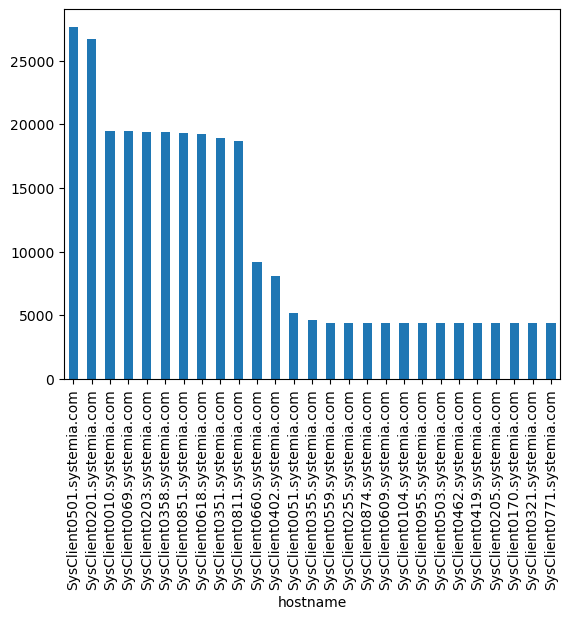

In [17]:
df_labels.toPandas().groupby('hostname')['id'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='action'>

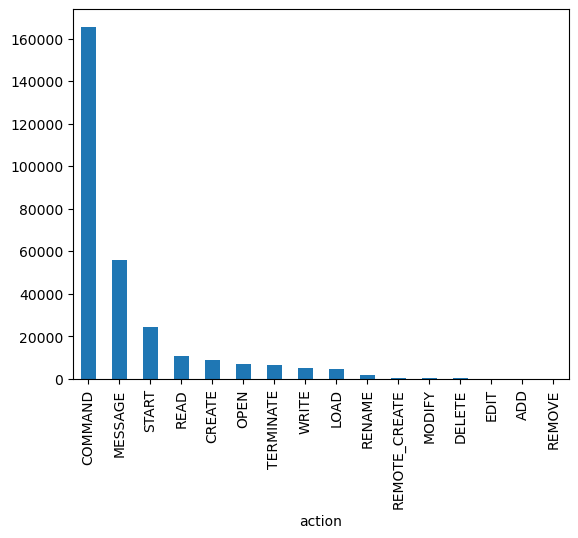

In [18]:
df_labels.toPandas().groupby('action')['id'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='object'>

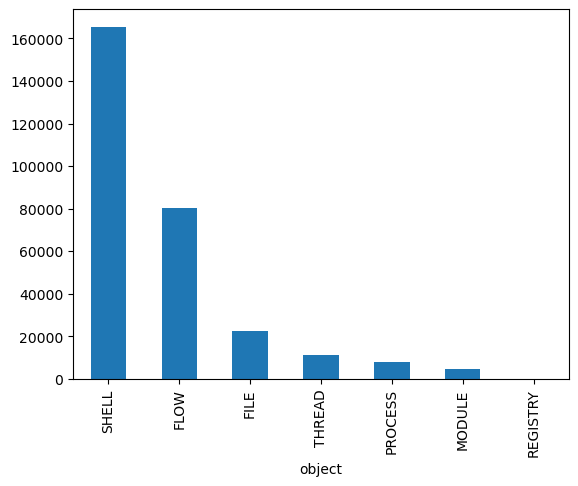

In [19]:
df_labels.toPandas().groupby('object')['id'].count().sort_values(ascending=False).plot(kind='bar')

In [20]:
df_labels.distinct()

DataFrame[hostname: string, id: string, objectID: string, actorID: string, timestamp: string, object: string, action: string]